# Repeated measurement of IQ

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf

INFO:bayesflow:Using backend 'jax'

In this example we build a model that estimates the IQ score of three
participants ($i \in (1, 2, 3)$), each taking part in three IQ tests
($j \in (1, 2, 3)$). The Bayesian graphical model is as follows

We use rather uninformative priors both for $\mu$ and for $\sigma$.
Follow this example and the book questions will lead to you to
customizing this workflow with different custom priors!

### Simulator

Again, we will use handcrafted summary statistics - in this case, we
just calculate the mean and standard deviation for each person.

In [2]:
def prior():
    mu=np.random.uniform(low=0, high=300, size=3)
    sigma=np.random.uniform(low=0, high=100)
    return dict(mu=mu, sigma=sigma)

def summary(x):
    mean = np.mean(x, axis=-2)
    sd = np.std(x, axis=-2)
    return dict(mean=mean, sd=sd)

def likelihood(mu, sigma):
    x=np.random.normal(loc=mu, scale=sigma, size=(3, 3))
    return summary(x)

simulator=bf.make_simulator([prior, likelihood])

### Approximator

In [3]:
adapter = (
    bf.Adapter()
    .constrain("mu", lower=0, upper=300)
    .constrain("sigma", lower=0, upper=100)
    .standardize(include=["mu", "sigma"])
    .concatenate(["mu", "sigma"], into="inference_variables")
    .concatenate(["mean", "sd"], into="inference_conditions")
    )

In [4]:
workflow=bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow()
)

### Training

In [ ]:
history=workflow.fit_online(epochs=50, batch_size=512)

### Validation

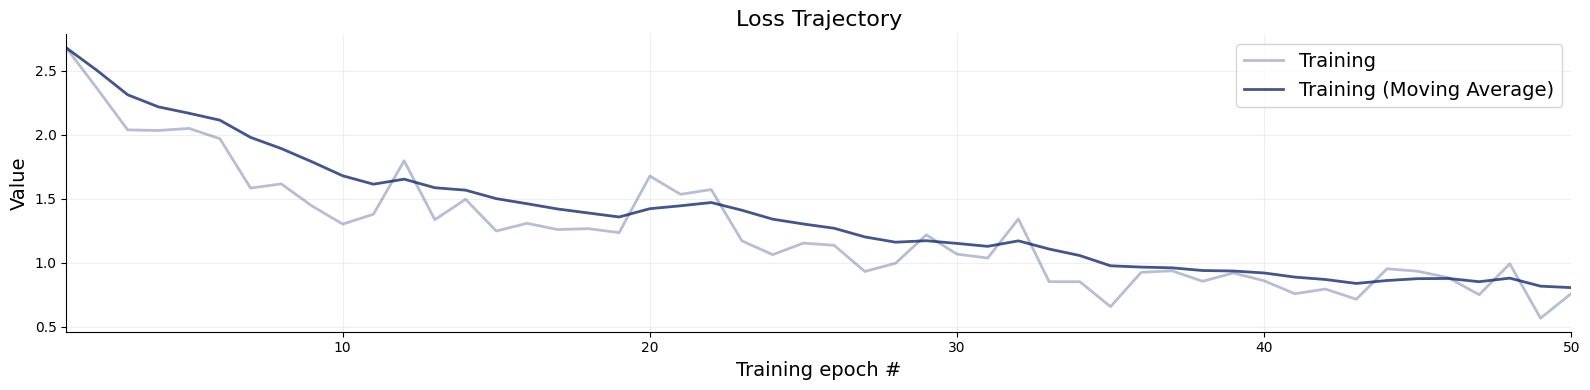

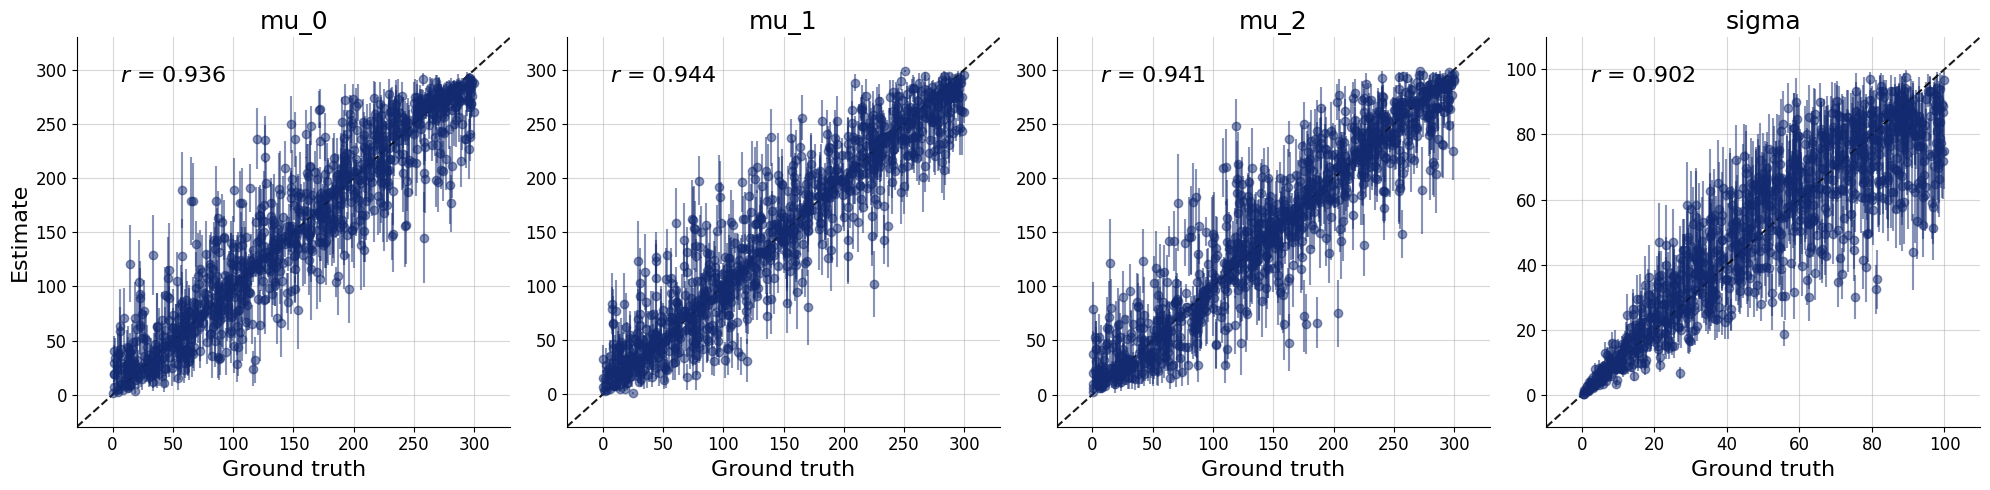

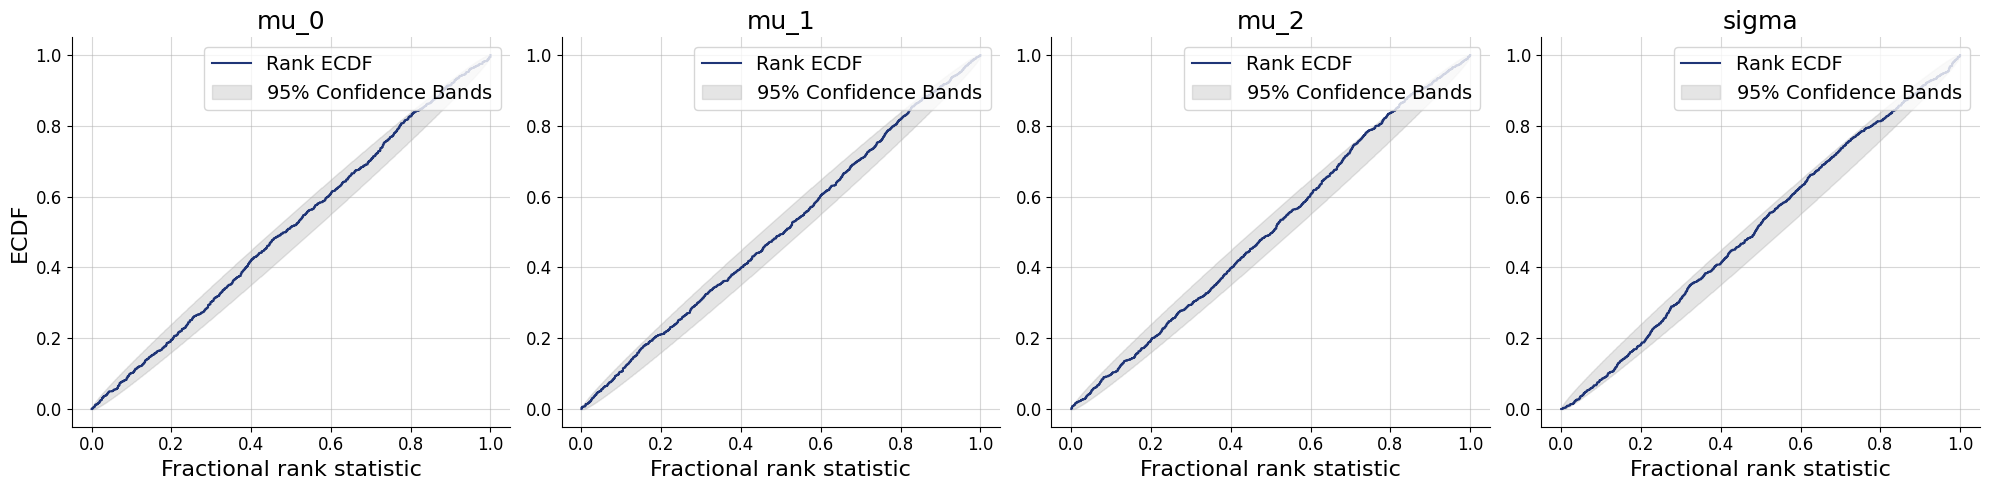

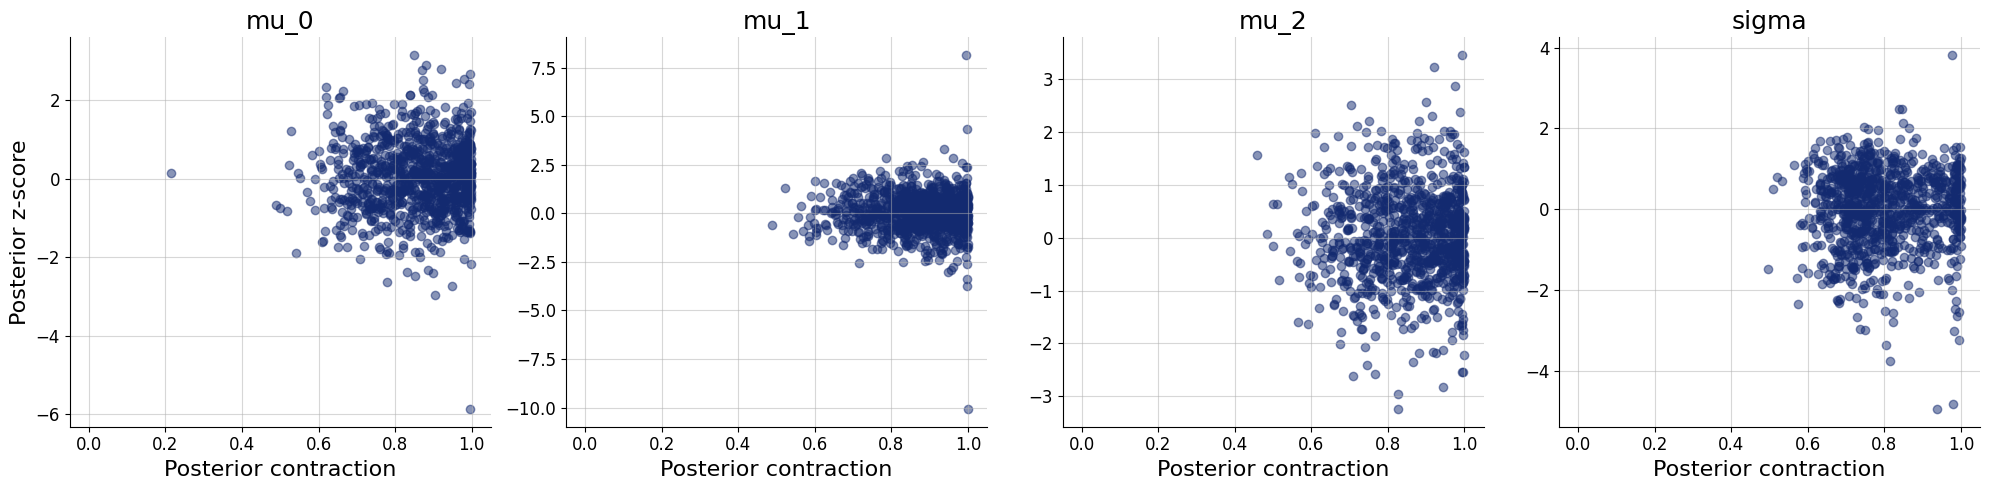

In [6]:
test_data=simulator.sample(1000)
figs=workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

In [7]:
x=np.array([
    [[ 90,  95, 100], 
     [105, 110, 115], 
     [150, 155, 160]]
    ])
x=x.swapaxes(1, 2)

inference_data=summary(x)

In [8]:
samples=workflow.sample(num_samples=2000, conditions=inference_data, split=True)

In [9]:
workflow.samples_to_data_frame(samples).describe().transpose()